In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# Parametros
L = 40 # Tamaño del dominio (en unidades adimensionales)
N = 3000 # Numero de puntos espaciales
dx = L / N  # Paso espacial
print(dx)
xi = np.linspace(-L / 2, L / 2, N)  # Grid espacial en unidades adimensionales
dt = 0.001  # Paso temporal (en unidades adimensionales)
t_max = 6.2 # Tiempo final (tiempo maximo tuneleo)
t_steps = int(t_max / dt)  # Numero de pasos temporales



# Parámetros del paquete de ondas, función de onda input
xi0 = -4  # Posición inicial partícula
kappa_0 = 5 # Momento Inicial
psi0 = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa_0 * xi)
psi0_star = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(-1j * kappa_0 * xi)

# Barrera de potencial
alpha_param = 100
v_0 = 4 # Altura del potencial (V_0/Ec)
b = 1 # Grosor de la barrera (en unidades adimensionales, realmente es xi_b)
v = v_0 / (1 + np.abs(xi / b)**alpha_param)  # Forma explicita del potencial
# v = v_0 * ( 1 - 1 / (1 + np.abs(xi / b)**alpha_param)) 

kmin = 0
kmax = 50


0.013333333333333334


In [9]:
def solve_crank_nicolson (kappa_0, dx, dt, v, psi0, t):

    t_steps = int(t / dt) 
        
    # Matrices Crank-Nicolson 
    alpha = 1j * dt / (kappa_0 * dx**2)  
    beta = 1j * dt * kappa_0 / 2  

    diagonal_a = (1 + alpha + beta * v) * np.ones(N)
    off_diagonal = -(alpha / 2) * np.ones(N - 1)
    A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

    diagonal_b = (1 - alpha - beta * v) * np.ones(N)
    B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")
    
    # Inicialización de la función de onda
    psi = psi0.copy()

    # Solución del problema
    for t in range(t_steps):
        psi = spsolve(A, B @ psi)

    return psi

In [10]:
def kinetic_energy(psi, xi):
    
    dx = xi[1] - xi[0]  
    d2psi_dx2 = np.gradient(np.gradient(psi, dx), dx)

    kinetic_energy = np.abs((1/kappa) * trapezoid(np.conjugate(psi) * d2psi_dx2, xi))
    
    return kinetic_energy

In [11]:
def calculate_positive_kappa_probability(psi, xi, kmax , kmin):
    k = np.fft.fftfreq(len(xi), d=xi[1] - xi[0]) * 2 * np.pi
    psi_k = np.fft.fft(psi) * (xi[1] - xi[0])  # Fourier transform
    
    a = kmin
    b = kmax    

    positive_k_mask = (k > a) & (k < b)
    
    prob_positive_k = np.sum(np.abs(psi_k[positive_k_mask])**2)
    
    total_prob = np.sum(np.abs(psi_k)**2)
    
    return prob_positive_k / total_prob

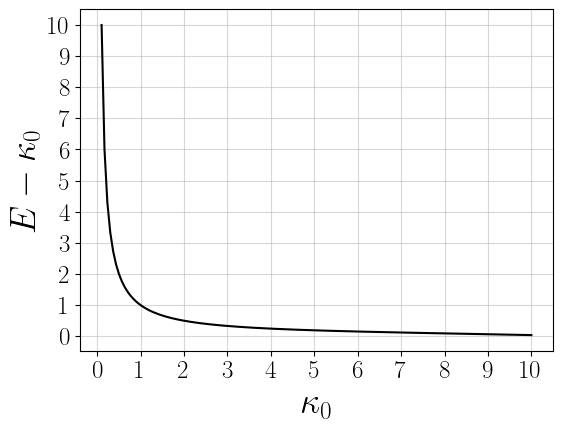

In [12]:
from matplotlib import rcParams

# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']  # Default LaTeX font

kappas = np.linspace(0.1, 10, 150)
energies = []

for kappa in kappas:
    psi = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa * xi)
    total_energy = kinetic_energy (psi, xi)
    energies.append ((total_energy-kappa))

fig = plt.figure(figsize=(6.1, 4.43))
plt.plot(kappas, energies, linestyle='-', color='k')
plt.xlabel(r"$\kappa_0$", fontsize = 26)
plt.tick_params(axis='both', labelsize=18) 
plt.xticks(range(0, 11, 1)) 
plt.yticks(range(0, 11, 1)) 
plt.grid(True, alpha = 0.5)
plt.ylabel(r"$E - \kappa_0$", fontsize = 26)
# plt.grid(True)
plt.show()



0.35992612660786255
0.21750231257308883
0.12238131161589665
0.06398479485951555
0.03034879114523383
0.01351933736565356
0.006115961712559263
0.002709299724974735
0.0010418976997935432
0.0003938017336640295
0.00023653282877957068
0.00019011413495502368
0.00014711880092508657
0.0001247563121102517
0.00012629343137509608
0.00013391503161043383
0.00013773203290240452
0.0001389902882798744
0.00014038295869981497
0.0001421742691322757
0.00014370383467018457
0.00014475143119983667
0.00014551491093155237
0.00014620012456547884
0.0001468387447801461
0.00014740598621643719
0.00014791794852356355
0.00014837504738606031
0.00014878536065766963
0.00014916952734469243
0.00014951227584161377
0.00014982569651800256
0.00015011759014060323
0.0001503757105276959
0.0001506249230156509
0.00015085164845199362
0.00015106542956638006
0.0001512739237775101
0.00015146195685686913
0.0001516532935952061
0.0001518241849384923
0.00015199428387393894
0.00015214810228673286
0.0001522898203071663
0.00015242238214276268

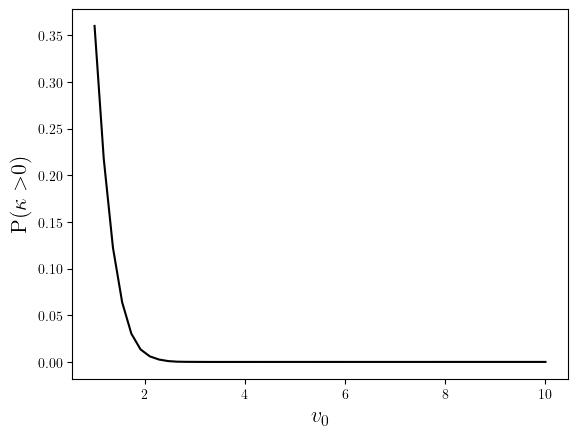

In [13]:
heights = np.linspace(1, 10, 50)
probabilities = []

for v_0 in heights:
    v = v_0 / (1 + np.abs(xi / b)**alpha_param)  # Forma explicita del potencial
    psi= psi0.copy()
    psi = solve_crank_nicolson(kappa_0, dx, dt, v, psi, t_max)
    p = calculate_positive_kappa_probability(psi, xi, kmax , kmin)
    probabilities.append (p)
    print(p)


plt.plot(heights, probabilities, linestyle='-', color='k')
plt.xlabel(r"$v_0$", fontsize = 16)
# plt.xticks(range(0, 11, 1)) 
# plt.yticks(range(0, 11, 1)) 
plt.ylabel(r"P($\kappa>$0)", fontsize = 16)
# plt.grid(True)
plt.show()

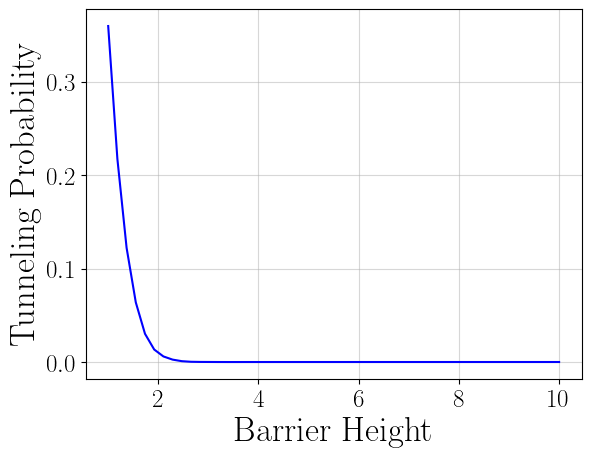

In [61]:
plt.plot(heights, probabilities, linestyle='-', color='blue')
plt.xlabel(r"Barrier Height", fontsize = 25)
# plt.xticks(range(0, 11, 1)) 
# plt.yticks(range(0, 11, 1)) 
plt.ylabel(r"Tunneling Probability", fontsize=25)
plt.tick_params(axis='both', labelsize=18) 
plt.grid(True, alpha = 0.5)

# plt.grid(True)
plt.show()

0.09839549376129746
0.07973734037350877
0.07179013907953989
0.05248118475569479
0.04958136782258157
0.03494684373212291
0.03320370935434424
0.023895259906953167
0.021977532293277105
0.016840206911192604
0.014533865876274546
0.012008044036521661
0.009680872282011681
0.008477890454250892
0.006547619222123736
0.0059001835274864346
0.004529332016658233
0.004081381008052284
0.003214349410051415
0.0028385251567043398
0.0023330251749071078
0.002006619289126617
0.0017223592922655589
0.0014555693341168259
0.0012911286242224059
0.0010911075342189712
0.0009867526374945789
0.0008482333589502072
0.0007741676274819687
0.0006837703131963289
0.0006272280871103529
0.0005700597870608626
0.0005261529904652996
0.00048988381131871
0.00045643526003945003
0.00043253039500488127
0.0004078213086046108
0.00039108069473475467
0.000373287275512357
0.0003608203542319159
0.0003481384093816441
0.00033841791029420794
0.00032928880183612013
0.00032149688471393894
0.00031472177657109883
0.00030837509874142373
0.0003031

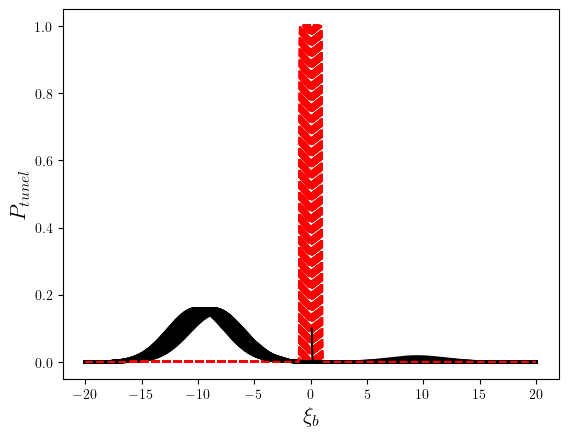

In [58]:
widths = np.linspace(0.1, 1,150)
probabilities1 = []

v_0 = 4


for b in widths:
    v = v_0 / (1 + np.abs((xi) / b)**alpha_param)  # Forma explicita del potencial
    psi= psi0.copy()
    psi = solve_crank_nicolson(kappa_0, dx, dt, v, psi, t_max)
    p = calculate_positive_kappa_probability(psi, xi, kmax , kmin)
    print(p)
    probabilities1.append (p)
    plt.plot(xi, np.abs(psi)**2,color='k',linewidth=2) # plot de |psi|^2
    plt.plot(xi, v/v_0, color='r', linestyle='--',alpha = 1 )

plt.plot(widths, probabilities1, linestyle='-', color='k')
plt.xlabel(r"$\xi_b$", fontsize = 16)
# plt.xticks(range(0, 11, 1)) 
# plt.yticks(range(0, 11, 1)) 
plt.ylabel(r"$P_{tunel}$", fontsize = 16)
# plt.grid(True)
plt.show()

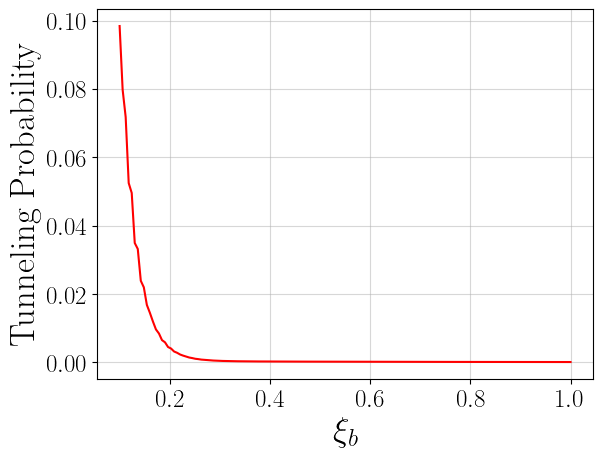

In [62]:
plt.plot(widths, probabilities1, linestyle='-', color='red')
plt.xlabel(r"$\xi_b$", fontsize = 25)
# plt.xticks(range(0, 11, 1)) 
# plt.yticks(range(0, 11, 1)) 
plt.ylabel(r"Tunneling Probability", fontsize=25)
plt.tick_params(axis='both', labelsize=18) 
plt.grid(True, alpha = 0.5)

# plt.grid(True)
plt.show()

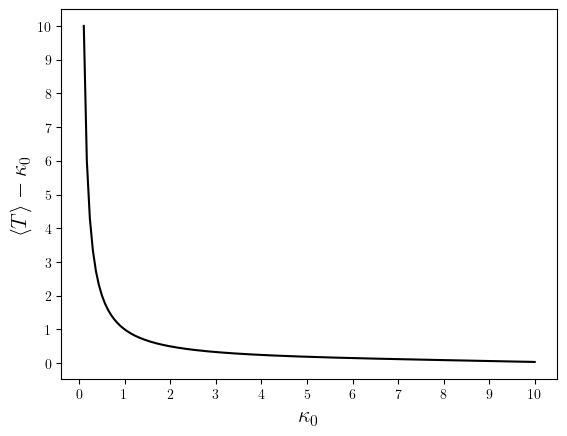

In [ ]:
from matplotlib import rcParams

# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']  # Default LaTeX font

kappas = np.linspace(0.1, 10, 150)
energies = []

for kappa in kappas:
    psi = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa * xi)
    total_energy = kinetic_energy (psi, xi)
    energies.append (total_energy-kappa)

plt.plot(kappas, energies, linestyle='-', color='k')
plt.xlabel(r"$\kappa_0$", fontsize = 16)
plt.xticks(range(0, 11, 1)) 
plt.yticks(range(0, 11, 1)) 
plt.ylabel(r"$\left \langle T \right \rangle - \kappa_0$", fontsize = 16)
# plt.grid(True)
plt.show()

